## Categorizing MNIST dataset using CNN (Convolutional Neural Networks) - Darsh Kale

### Import Libraries 

In [1]:
import numpy as np
import torch
import torchvision
import gzip
import matplotlib.pyplot as plt
import warnings
from torch.utils.data import DataLoader

C:\Users\darsh\anaconda3\envs\ml\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: [WinError 126] The specified module could not be found
  warn(f"Failed to load image Python extension: {e}")


### Enable Cuda (GPU computation)

With the folllowing line we can set device to be run on the GPU instead of the CPU. For datasets that are huge a GPU may provivde much faster model training speeds compared to CPU's. This is because GPU's allow for heavy parallelization due to the large amount of cores they have high data throughput in camparison to the smaller amount (but faster) that CPU's have. However in our case, the MNIST datset is small enough and our model complexity is not that high, so the GPU's benefits of parallelization/high data throughput are overpowered by the CPU file I/O speeds. Note that this only works if your have Cuda version installed on your device that is compatible with the pytorch version you are using. Additionaly you must also ensure that your GPU is compatible with the Cuda toolkit. 


In [2]:
## UNCOMMENT LINE BELOW FOR GPU
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device

### Download/Extract Data

Since the MNIST dataset is already size-normalized and centered we could download the data from [website](http://yann.lecun.com/exdb/mnist/) into a folder, and extract it using libraries such as gzip (look [here](https://stackoverflow.com/questions/40427435/extract-images-from-idx3-ubyte-file-or-gzip-via-python) for detailed explanations). However, out of convenience we simply use [this](https://stackoverflow.com/questions/64080130/how-to-import-the-mnist-dataset-from-local-directory-using-pytorch/64081743#64081743) solution that downloads and extracts data from the torchvision library. Note that we also transform each image into a tensor, which will be useful later into this project as we will build a CNN using the torch library.

In [3]:
# Not adviced to add the following line, however we want to format our outputs. Thus we get rid of warnings as such:
warnings.filterwarnings("ignore")

train_data = torchvision.datasets.MNIST(
    root = 'samples',
    # ToTensor() normalizes images between 0.0 and 1.0
    transform = torchvision.transforms.ToTensor(), 
    train = True,    
    download = True,            
)

test_data = torchvision.datasets.MNIST(
    root = 'samples', 
    train = False, 
    transform = torchvision.transforms.ToTensor()
)

We can check to see if we correctly retrieved the data, by plotting one of the images and its respective label:

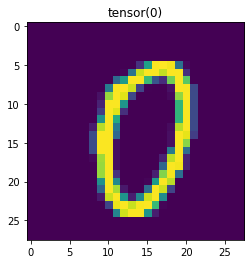

torch.Size([28, 28])

In [4]:
plt.imshow(train_data.data[1000])
plt.title(train_data.targets[1000])
plt.show()

train_data.data[1].size()


### Set up DataLoaders

DataLoaders simplify preprocessing our data, before we use it for training our model. They can split our dataset into batches and shuffle the data (increases generalization). It is a Map-style dataset, which means it provides random-access capabilities, which allow for easier parallel loading (useful for large datasets like ours).

The reasoning behind the parameters we set for DataLoader function:
* batch_size: A smaller batch size would have more parameter updates per epoch and would be more noisy as loss is calculated over a smaller subset (less overfitting). We chose 128 as our batch size, which is on the smaller side.
* shuffle: When shuffle is True, it helps to not have data look alike bwtween epochs. By default shuffle=True uses RandomSampler, while false uses SequentialSampler.
* num_workers: General rule of thumb, num_workers = num_GPU * 4; when num_workser=0 it does data loading when needed.

In [5]:
batch_size = 128 
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=0)

### Building our Model

CNN is a class of neural newtork that is most commonly used to process images. It consists of two main steps. The first step extracts the most important features. It does so using the 3 layers: Covolutional lauer, ReLU correction lauer, and the Pooling layer (in the same order). In our model below we apply these 3 layers 3 times for this first part of our model. For the 2nd part of our model we take the output from the previous part apply linear combinations and the softmax activation function, which gives an output vector of size 10 (since we have 10 classes). 

#### Part 1

Layer 1,2 parameters:
The first convulutional layer has the following parameters:
* in_channels: We set this to 1 since we have a greyscale image (values range from 0 to 255)
* out_channel: This is the number of channels (feature maps), we use 32.
* kernel_size: We chose a 3x3 kernel size. Generally odd kernel sizes are preferred over even since they symmetrically divide the previous layer pixels around the output pixel
* stride: A higher stride equates to less data needs to be processed, more generalization. We chose stride of 1 as our image is small(28x28) more information preserved.
* padding: We choose padding=0 as the information at the edges of the images is unnecessary since the numbers are centered

ReLU function has no parameters

Layers 3-6 parameters:
The convulutional functions have their in_channel set to the out_channel of the previous convulution layer. Their ou_channel is half of their current in_channel. Stride, kernel_size, and padding remain the same. ReLU once again, takes in no parameter.

Layer 7 parameters:
Initially we had maxpooling layers after each convulutional + ReLU layer, however this resulted in too much data loss, and increased model training time. We removed 2 of these max pooling layers, only keeping the last max pooling layer, which marks the end of part 1. 

Max Pooling function:
* kernel_size: We set this to 2 as we want to minimize information loss since our images are already small and lower quality.

#### Part 2

Layer 8 parameters:
Flatten takes in no parameters. This function takes each batch of images and flattens each image seperately (reduces the matrix into vector form).

Layers 9-11 parameters:
the torch.nn.linear function applies a linear transformation, y=x*w^T + b where x is the incoming data, 
y is the output, W are the weights (initially random) and b are the biases that are both updated during the training of our model. In the end, our goal is to transform the output from layer 8 into a vector of length 10, which will be the probabilities for each class 0-9.

Linear transformation function: 
For layer 9:
* in_channels: this is the size (# of features) for input. Since the output from layer 8 has the dimensions 128 x 968, our input for in_channels will be 968. This will allow a valid form of matrix multiplication where x is (128 x 968) and W will be (968 x out_channels).
* out_channels: We set this 512. Note we are ultimately trying to reduce this to 10. We choose some number x that is smaller than the in_channels and where x = 2^n for some n to make the computation efficient. 
* bias: this is set to true by default and will be included in our model. 
For layer 10, 11:
The in_channel will be the out_channel of the previous layer. The final out_channel (layer 11) wil be 10 since there will be a probability for each of our 10 classes.



In [6]:
model = torch.nn.Sequential(
                                                ### 1st Part
    # layers 1,2
    torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=0),
    torch.nn.ReLU(),
    #torch.nn.MaxPool2d(kernel_size=2),
    
    # layers 3,4
    torch.nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, stride=1, padding=0),
    torch.nn.ReLU(),
    #torch.nn.MaxPool2d(kernel_size=2),
   
    # layers 5,6
    torch.nn.Conv2d(in_channels=16, out_channels=8, kernel_size=3, stride=1, padding=0),
    torch.nn.ReLU(),
    
    # layer 7
    torch.nn.MaxPool2d(kernel_size=2),
                                                ### 2nd Part
    
    # layer 8
    torch.nn.Flatten(),
    
    # layer 9,10,11
    torch.nn.Linear(in_features=968, out_features=512),
    torch.nn.Linear(in_features=512, out_features=128),
    torch.nn.Linear(in_features=128, out_features=10)   
)

### Loss and Optimization Function

#### Loss Function
For our loss function we use the Multiclass Cross Entropy Loss function as it is suitable for our image classification problem This function gives a measure of how close the true distribution of probabilities for the classes (numbers 0-9) is to our predicted distribution. Our goal during fitting our model is to minimize the loss calculated by this function.

#### Optimization Function
Our optimizatoin function is Adam (Adaptive Moment Estimation) type. It is an extension to the stochastic gradient decent algorithm, and has large adoption in deeplearning applications in computer vision due to its simplicity and effectiveness. [This](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/) link gives a more detailed explanation of this function. THe learning rate (a.k.a. alpha or step size) is the proportion the weights (W in the torch.nn.Linear method) is updated by. Larger learning rates may reach a conclusion in less updates however them may also lead to divergence if set too high, on the other hand small learning rates would take many more updates to arrive at a global minima (for loss) or may find a local minima instead of a global one. Finding the right learning rate is a complex process, and [this](https://www.jeremyjordan.me/nn-learning-rate/) article provide a detailed guide on how one might find the best learning rate for your model. We choose a learning rate of 1e-4 (After a non-sytematic approach of randomly trying different lr's and comparing their accuracy). The default parameters (that we use) are beta1=0.9, beta2=0.999, epsilon=1e-8.

In [15]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

### Training the Model

To train our model we first decide how many epochs to train it over. Training it for too many epochs may result in overfitting, while too little would result in lower accuracy (higher loss). We first choose a fairly large number ~20 epochs and check at what epoch our loss stops decreasing and starts increasing (avg of 2-3 epochs) or the decrease in loss is unsubstantial. We determine that 7 epochs seems to be optimal in our case. Next for each batch of data from the train_dataloader we first set our optimizers weights to zero with zero_grad(). Next we get the predicted probabilites (transformed by torch.nn.linear) for each class for that batch of data. We then calculate loss based on this output and the true label for the training data set. Next, loss.backward() is the back propgation step that finds the updates for our parameters and optimizer.step() actually updates the parameters.

In [22]:
## UNCOMMENT LINE BELOW FOR GPU
#model.to(device)
for epoch in range(7):
    for data in train_loader:
        images, labels = data
        ## UNCOMMENT LINE BELOW FOR GPU
        # images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(images)   
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
    print(epoch, loss)

0 tensor(0.0057, grad_fn=<NllLossBackward0>)
1 tensor(0.0155, grad_fn=<NllLossBackward0>)
2 tensor(0.0171, grad_fn=<NllLossBackward0>)
3 tensor(0.0140, grad_fn=<NllLossBackward0>)
4 tensor(0.0425, grad_fn=<NllLossBackward0>)
5 tensor(0.0138, grad_fn=<NllLossBackward0>)
6 tensor(0.0062, grad_fn=<NllLossBackward0>)


### Testing the Model

We finally test our model on the training dataset. The torch.no_grad() function disables gradient calculations over the weights (note: this will NOT affect the accuracy of the model) reducing memory consumption. Next we get all the batches of data from the test_loader, and get the prdicted probabilities (note, these are after applying the linear transformation so range is not 0 to 1, but magnitude/order is the same) for each class. Then using the torch.max() function we get the maximum value from the tensors (returns both value and index). We increment total number of imagess (this will be 10,000 at the end) and also increment the number of images correctly classified for that particular batch of images. Finally we calculate the test accuracy by dividing the total correctly classified images by total images. 

In [24]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0], data[1]
        outputs = model(images)
        predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted[1] == labels).sum().item()
print("Test accuracy: ", correct / total)

Test accuracy:  0.9872


### Conclusion
Our test accuracy is over 97% consistently. Running this notebook again may not produce the same results since dataloader randomly choses images for batches which will affect the training of our final model. Overall, convolutional neural networks seem to be ideal for training models to categorize images quickly and accurately.